# Step 1
# Get RR peaks

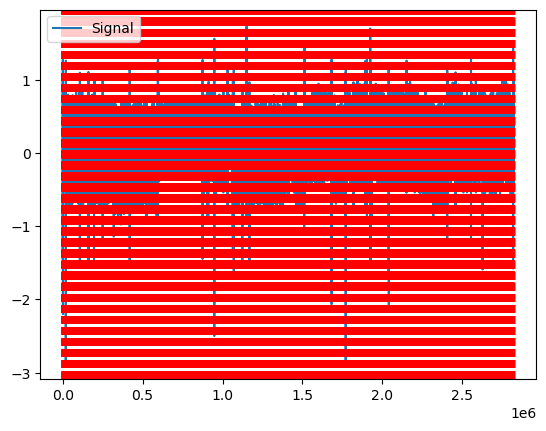

In [256]:
import neurokit2 as nk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Generate a time axis
t_test = np.linspace(0, 2*np.pi, 1000)
signal_test = np.sin(t_test)

df = pd.read_csv("a02.csv", usecols=["ECG"])
ecg = np.concatenate(pd.DataFrame(df["ECG"]).to_numpy())

rpeaks, info = nk.ecg_peaks(ecg, sampling_rate=100)
nk.events_plot(info["ECG_R_Peaks"], ecg)

# Step 2
# Sectioning

In [257]:
def R_peaks_section(start_time, stop_time):
   
    df = pd.read_csv("a02.csv", usecols=["Time"])
    Time = np.concatenate(pd.DataFrame(df["Time"]).to_numpy())
    Time_List = Time.tolist()

    start_position = Time_List.index(start_time)
    stop_position = Time_List.index(stop_time)
    Peaks = info["ECG_R_Peaks"]
    section = []
    for peak in Peaks:
        if peak >= start_position and peak <=stop_position:
            section.append(Time[peak])
    return section 


# Step 3 
# Transform RR peaks into intervals

431

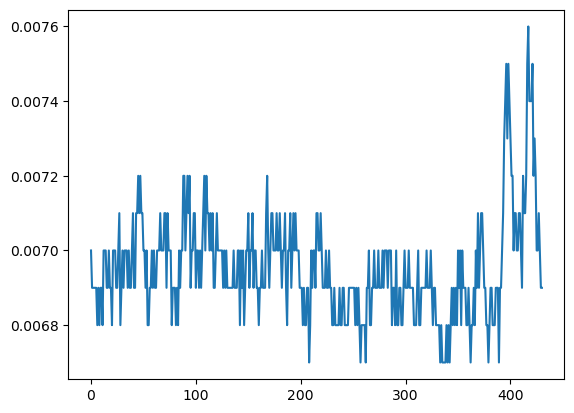

<Figure size 1000x600 with 0 Axes>

In [268]:
hrv_section = R_peaks_section(9100.01, 9400.01)

# Calculate RR intervals in seconds
rr_intervals = np.diff(hrv_section) / 100

# Convert RR intervals to milliseconds
rr_intervals_ms = rr_intervals * 1000

# Convert RR intervals to a pandas DataFrame
plt.plot(rr_intervals)
plt.figure(figsize=(10, 6))
#print(rr_intervals[:20])
#print(info["ECG_R_Peaks"][:20])
np.size(rr_intervals)

# Step 4 
# Clean HRV outliers?

# Step 5
# Cut the mean

[-0.06046272 -0.07546272 -0.06046272 -0.02546272 -0.00046272 -0.00046272
  0.02953728  0.08953728  0.11953728 -0.00046272 -0.00046272 -0.05046272
 -0.09046272 -0.11546272 -0.08046272 -0.16546272 -0.12046272 -0.11046272
 -0.09546272 -0.11546272]


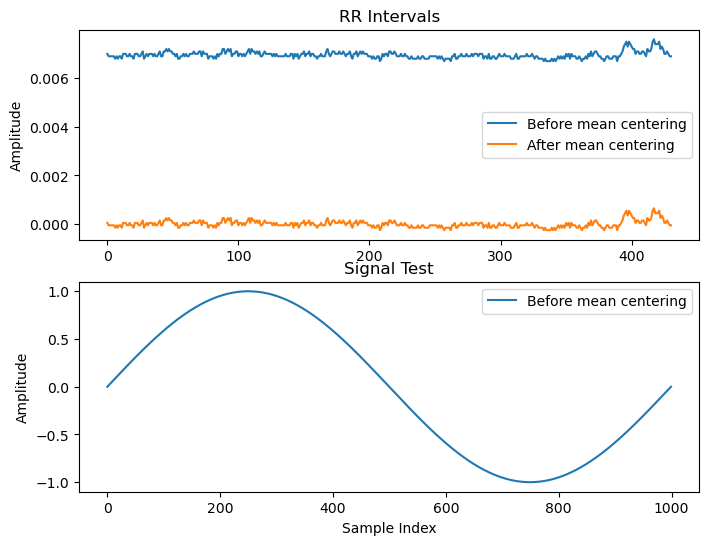

In [266]:

rr_intervals_without_mean = rr_intervals - np.mean(rr_intervals)
signal_testwithout_mean = signal_test - np.mean(signal_test)
print(rr_intervals_np_without_mean[:20])
# Plot the data
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(rr_intervals,label='Before mean centering')
plt.plot(rr_intervals_without_mean, label='After mean centering')
plt.legend()
plt.title('RR Intervals')
plt.ylabel('Amplitude')
plt.subplot(2, 1, 2)
plt.plot(signal_testwithout_mean, label='Before mean centering')
#plt.plot(signal_test, label='After mean centering')
plt.legend()
plt.title('Signal Test')
plt.ylabel('Amplitude')
plt.xlabel('Sample Index')
plt.show()

# Step 6
# Window: taper with Hamming Filter

<Figure size 1000x500 with 0 Axes>

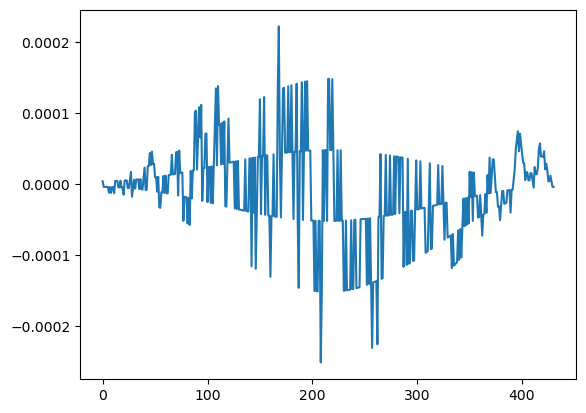

<Figure size 1000x500 with 0 Axes>

In [272]:
window_hamming = np.hamming(len(rr_intervals_without_mean))
rr_intervals_windowed_hamming = rr_intervals_without_mean * window_hamming
plt.plot(rr_intervals_windowed_hamming)
plt.figure(figsize=(10, 5))

# 1/8 of a Sine wave filter

<Figure size 1000x500 with 0 Axes>

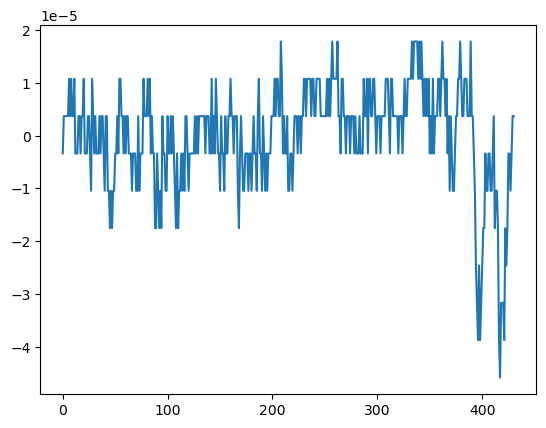

<Figure size 1000x500 with 0 Axes>

In [273]:
window_sine = np.sin(len(rr_intervals_without_mean))/8
rr_intervals_windowed_sine = rr_intervals_without_mean * window_sine
plt.plot(rr_intervals_windowed_sine)
plt.figure(figsize=(10, 5))

# Hanning Filter

<Figure size 1000x500 with 0 Axes>

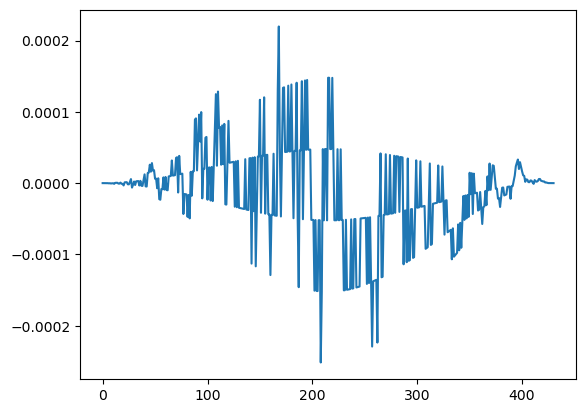

<Figure size 1000x500 with 0 Axes>

In [274]:
window_hanning = np.hanning(len(rr_intervals_without_mean))
rr_intervals_windowed_hanning = rr_intervals_without_mean * window_hanning
plt.plot(rr_intervals_windowed_hanning)
plt.figure(figsize=(10, 5))

In [275]:
from scipy.signal import butter, filtfilt

def butterworth_filter(signal, cutoff_freq, fs, order=5, filter_type='lowpass'):
    """
    Applies a Butterworth filter to a signal.

    Parameters:
        signal (ndarray): The signal to filter.
        cutoff_freq (float): The cutoff frequency of the filter.
        fs (float): The sampling frequency of the signal.
        order (int, optional): The order of the filter. Defaults to 5.
        filter_type (str, optional): The type of filter to apply. Can be 'lowpass', 'highpass', 'bandpass', or 'bandstop'. Defaults to 'lowpass'.
    
    Returns:
        ndarray: The filtered signal.
    """
    # Calculate the normalized cutoff frequency
    nyquist_freq = 0.5 * fs
    cutoff_freq_norm = cutoff_freq / nyquist_freq

    # Define the filter coefficients
    if filter_type == 'lowpass':
        b, a = butter(order, cutoff_freq_norm, btype='lowpass')
    elif filter_type == 'highpass':
        b, a = butter(order, cutoff_freq_norm, btype='highpass')
    elif filter_type == 'bandpass':
        b, a = butter(order, [cutoff_freq_norm[0], cutoff_freq_norm[1]], btype='bandpass')
    elif filter_type == 'bandstop':
        b, a = butter(order, [cutoff_freq_norm[0], cutoff_freq_norm[1]], btype='bandstop')

    # Apply the filter using the filtfilt function for zero-phase filtering
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal


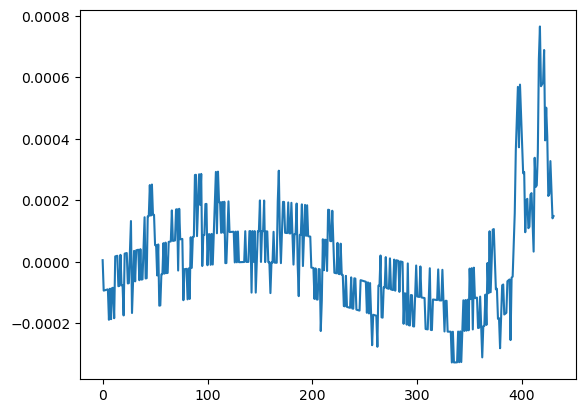

In [276]:
rr_intervals_highpass = butterworth_filter(rr_intervals_without_mean, cutoff_freq=0.15, fs=100, order=5, filter_type='highpass')
plt.plot(rr_intervals_highpass)

# Step 7
# Calculate the FFT

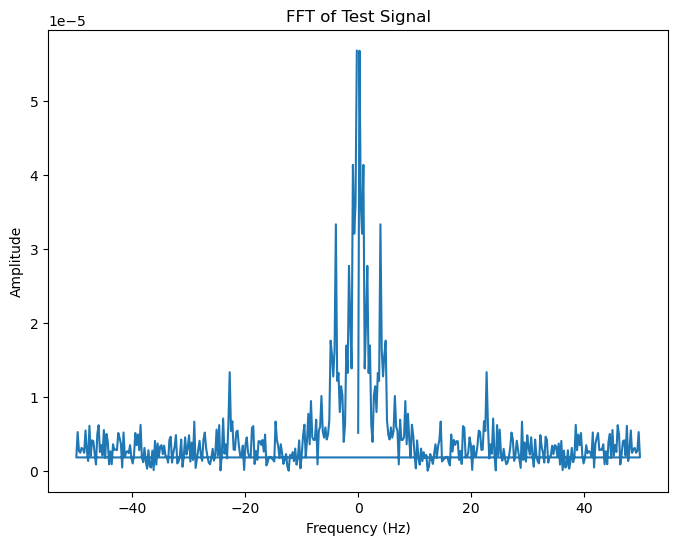

In [277]:
fsamp=100

fft_test= np.fft.fft(signal_test)
fft_test_freq= np.fft.fftfreq(len(t_test), t_test[1]-t_test[0])

fft = np.fft.fft(rr_intervals_highpass)
freqs = np.fft.fftfreq(len(rr_intervals_highpass))*fsamp


# Plot the FFT
plt.figure(figsize=(8, 6))
plt.plot(freqs, np.abs(fft)/len(rr_intervals_highpass))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of Test Signal')
plt.show()

# Step 8

# PSD based on FFT 
# Note: Using Log Scale

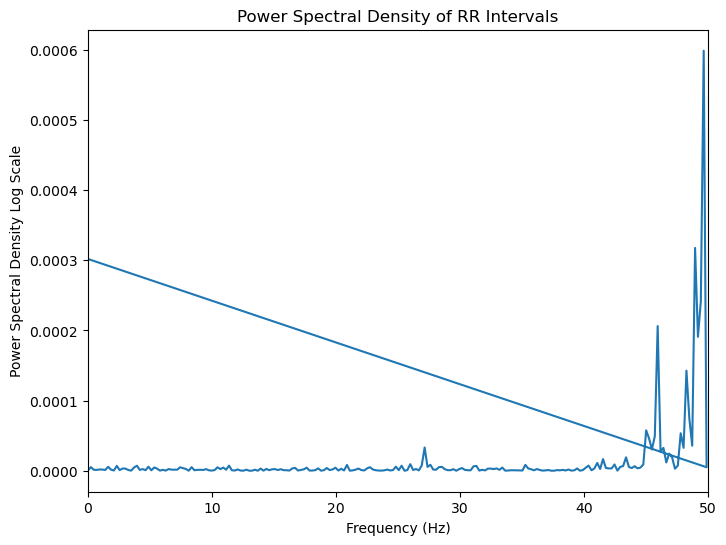

In [284]:
PSD_bias = PSD / sum(window_hanning**2)/len(rr_intervals_windowed_hanning)
PSD = np.fft.fftshift(np.abs(fft)**2)
PSD_dB = 10*np.log10(PSD)

# Create a frequency axis
freqs = np.fft.fftfreq(len(rr_intervals_highpass))*fsamp


# Plot the PSD
plt.figure(figsize=(8, 6))
plt.plot(freqs, PSD)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density Log Scale')
plt.title('Power Spectral Density of RR Intervals')
plt.xlim([0, fsamp/2])
plt.show()

# Log Scale: Only positive frequencies

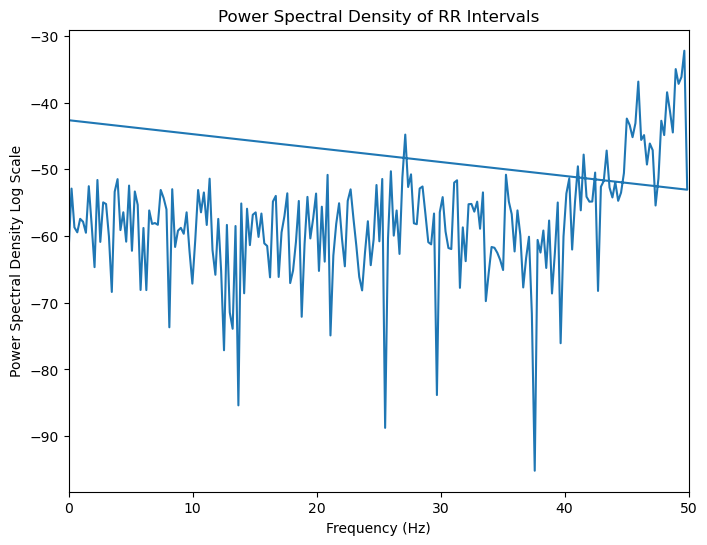

In [285]:
# Shift the zero frequency component to the center of the array
fft_shifted = np.fft.fftshift(fft)
freqs_shifted = np.fft.fftshift(freqs)

# Plot the PSD
plt.figure(figsize=(8, 6))
plt.plot(freqs, PSD_dB)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density Log Scale')
plt.title('Power Spectral Density of RR Intervals')
plt.xlim([0, fsamp/2])
plt.show()

# PSD without Log Scale

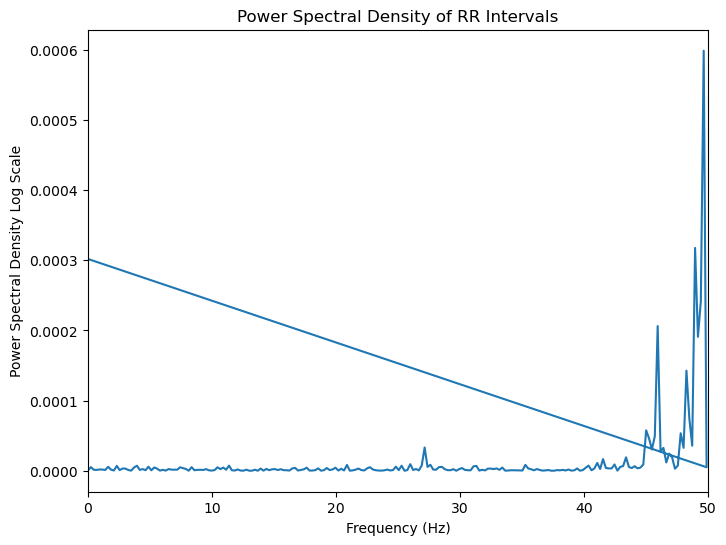

In [286]:
plt.figure(figsize=(8, 6))
plt.plot(freqs, PSD)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density Log Scale')
plt.title('Power Spectral Density of RR Intervals')
plt.xlim([0, fsamp/2])
plt.show()

# PSD without Log Scale, Only positive frequencies

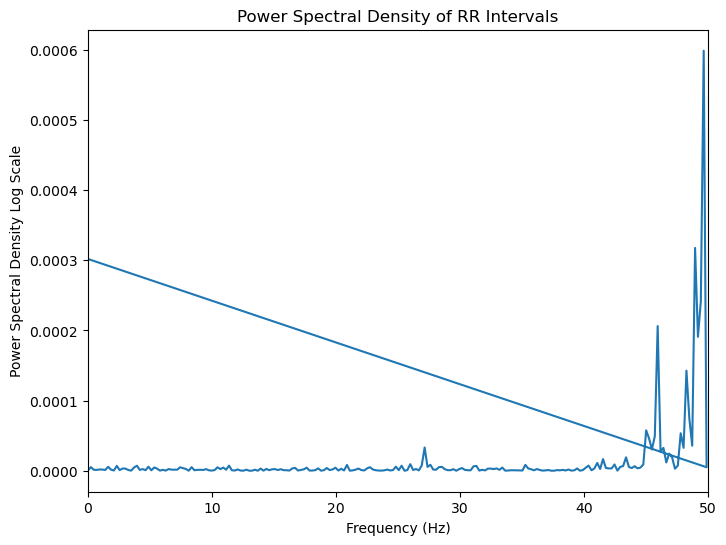

In [287]:
# Plot the PSD
plt.figure(figsize=(8, 6))
plt.plot(freqs, PSD)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density Log Scale')
plt.title('Power Spectral Density of RR Intervals')
plt.xlim([0, fsamp/2])
plt.show()

# Normalised PSD 

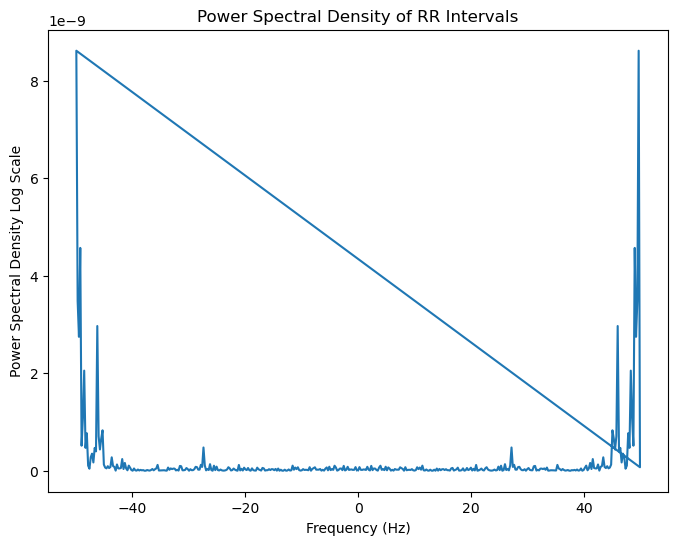

In [288]:
# Plot the PSD
plt.figure(figsize=(8, 6))
plt.plot(freqs, PSD_bias)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density Log Scale')
plt.title('Power Spectral Density of RR Intervals')
plt.show()

In [134]:
import os
os.chdir("/Users/marianarodrigues/Documents/Jupyter/ImagesAndColourmaps-ForClassroom/ECG_Resp")